# Felipe Cardona - Tarea 3 Clasificación De Datos Utilizando Imágenes

## Configurar e Importar dependencias necesarias.

In [1]:
pip install -r requirements.txt

In [2]:
import os
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

## Cargar las imagenes para entrenamiento

Al momento de cargar nos encargaremos de eliminar todas aquellas imagenes corruptas que no sean posible de leer y tambien de normalizar las imagenes.

In [3]:
trainPath = 'data/train'
# Defino las dimensiones de las imágenes para estandarizar el procesamiento
IMG_SIZE_LR = 64  # Tamaño reducido para el modelo de regresión logística
IMG_SIZE_CNN = 128      # Tamaño para el modelo CNN

# Mapeo de etiquetas para corrección de nombres
labelMapping = {
    "Shepherds Purse": "Shepherd’s Purse",
}
def loadImages(path, imgSize=IMG_SIZE_LR, grayscale=False):
    """
    Carga y procesa las imágenes desde el directorio especificado.
    Parámetros:
    - path (str): Ruta de la carpeta de imágenes.
    - imgSize (int): Tamaño al que se redimensionarán las imágenes.
    - grayscale (bool): Si es True, carga las imágenes en escala de grises. Por defecto es False (color).
    
    Retorna:
    - images (np.array): Arreglo de imágenes procesadas.
    - labels (np.array): Arreglo de etiquetas correspondientes.
    """
    images = []
    labels = []
    for folder in os.listdir(path):
        label = labelMapping.get(folder, folder)  # Usar el mapeo de etiquetas si está definido
        folderPath = os.path.join(path, folder)
        if not os.path.isdir(folderPath):
            continue
        for file in glob.glob(os.path.join(folderPath, "*.png")):
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
            if img is None:
                print(f"Error al cargar la imagen: {file}")
                continue
            img = cv2.resize(img, (imgSize, imgSize))
            img = img / 255.0
            images.append(img)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    if grayscale:
        images = images.reshape(-1, imgSize, imgSize, 1) # Ajustar la dimensión del canal para imágenes en escala de grises
    return images, labels

### Pasaremos a codificar etiquetas y dividir los datos los datos en entrenamiento y validación

In [3]:
X, y = loadImages(trainPath,IMG_SIZE_LR,True) # Cargar imágenes y etiquetas para el modelo de regresión logística

# Codificar las etiquetas
labelEncoder = LabelEncoder()
yEncoded = labelEncoder.fit_transform(y)
yEncoded = to_categorical(yEncoded)

# Dividir en conjuntos de entrenamiento y validación
XTrain, XVal, yTrain, yVal = train_test_split(X, yEncoded, test_size=0.2, random_state=42)

### Pasaremos a realizar ajustes y a entrenar el modelo de Regresión Logistica

In [19]:
# Aplanar las imágenes
XTrainFlat = XTrain.reshape(XTrain.shape[0], -1)
XValFlat = XVal.reshape(XVal.shape[0], -1)

In [20]:
from sklearn.pipeline import make_pipeline

# Crear el modelo de regresión logística con un pipeline
logisticModel = make_pipeline(
    LogisticRegression(max_iter=1500, solver='lbfgs', C=1)
)

logisticModel.fit(XTrainFlat, yTrain.argmax(axis=1))

Pipeline(steps=[('logisticregression', LogisticRegression(C=1, max_iter=1500))])

### Realizando predicciones con los datos de entrenamiento conseguimos los siguientes resultados

In [21]:
# Evaluar el modelo de Regresión Logística
yValPred = logisticModel.predict(XValFlat)
accuracy = accuracy_score(yVal.argmax(axis=1), yValPred)
confMatrix = confusion_matrix(yVal.argmax(axis=1), yValPred)

print("Precisión del modelo de Regresión Logística:", accuracy)
print("Matriz de Confusión:\n", confMatrix)

Precisión del modelo de Regresión Logística: 0.13123844731977818
Matriz de Confusión:
 [[ 4  4  2  8  0  9 13  1  5  0  9  1  0  0  0  3]
 [ 0  8  2 16  3  5 10  1 16  4 17  5  0  0  0  0]
 [ 0  6  2  8  2  3  9  0 12  6  8  1  0  0  0  0]
 [ 3  6  3 34  1 12 17  2 18  3 11  7  1  0  2  0]
 [ 1  3  0  4  0  9 16  1  6  2  8  5  1  0  0  0]
 [ 3  4  5 17  1 17 20  4 12  3  7  6  0  0  0  0]
 [ 5 12  5 17  1 19 20  2 17  8 10  5  0  0  1  0]
 [ 0  1  2 11  0  5 10  0  3  2  6  0  0  1  0  0]
 [ 0  4  6 28  1 12 19  5 19  4  9  6  0  0  0  0]
 [ 0  2  2  3  3  2  9  1 10  1  9  1  0  0  0  0]
 [ 3  7  8 12  1  5 13  7 16  2 14  0  0  0  0  0]
 [ 4  5  2 13  1  7 17  2  7  3  8  8  0  0  0  2]
 [ 1  0  2  1  1  3  1  0  1  1  0  1  7  2  8  6]
 [ 2  0  2  1  1  5  2  2  1  0  0  1  2  3  2  2]
 [ 2  0  2  6  0  2  3  0  1  0  0  2  4  1  3  4]
 [ 1  1  5  1  0  5  2  1  1  1  1  1  2  1  2  2]]


### Creando método para crear la matriz de forma visual

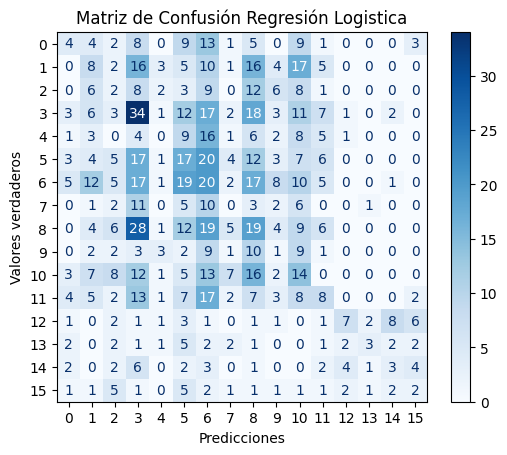

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plotConfusionMatrixWithCounts(yTrue, yPred, title="Matriz de Confusión"):
    """
    Grafica la matriz de confusión y muestra los valores TP, TN, FP y FN.

    Parámetros:
    yTrue -- Valores verdaderos (etiquetas reales).
    yPred -- Valores predichos por el modelo.
    title -- Título de la gráfica (opcional, por defecto es "Matriz de Confusión").
    """
    confMatrix = confusion_matrix(yTrue, yPred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMatrix)
    disp.plot(cmap="Blues")
    # Configura la gráfica
    plt.title(title)
    plt.xlabel("Predicciones")
    plt.ylabel("Valores verdaderos")
    plt.show()
    
plotConfusionMatrixWithCounts(yVal.argmax(axis=1), yValPred, "Matriz de Confusión Regresión Logistica")

### Ahora cargaremos las imagenes de test con el fin de poner a prueba la predicción del modelo.

In [2]:
testPath = "data/test"

def loadTestImages(path, imgSize=IMG_SIZE_LR, grayscale=False):
    """
    Carga y procesa las imágenes de prueba desde el directorio especificado.
    
    Parámetros:
    - path (str): Ruta de la carpeta de imágenes de prueba.
    - imgSize (int): Tamaño al que se redimensionarán las imágenes.
    - grayscale (bool): Si es True, carga las imágenes en escala de grises. Por defecto es False (color).
    
    Retorna:
    - testImages (np.array): Arreglo de imágenes de prueba procesadas.
    - filenames (list): Lista de nombres de archivo correspondientes.
    """
    images = []
    filenames = []
    for file in os.listdir(path):
        imgPath = os.path.join(path, file)
        img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
        img = cv2.resize(img, (imgSize, imgSize))
        img = img / 255.0
        if grayscale:
            img = np.expand_dims(img, axis=-1)
        images.append(img)
        filenames.append(os.path.basename(file))
    return np.array(images), filenames

NameError: name 'IMG_SIZE_LR' is not defined

### Creamos la función que realice la predicción y genere el archivo para subir a Kaggle.

In [4]:
# Función para realizar predicciones y guardar el archivo CSV para Kaggle
import pandas as pd

def predictAndSave(model, xTest, filenames, labelEncoder, outputFile="submission.csv"):
    """
    Realiza predicciones usando el modelo dado y guarda los resultados en un archivo CSV.
    
    Parámetros:
    - model: Modelo entrenado para realizar predicciones.
    - xTest (np.array): Imágenes de prueba en formato aplanado.
    - filenames (list): Lista de nombres de archivo correspondientes a cada imagen de prueba.
    - labelEncoder (LabelEncoder): Codificador de etiquetas para decodificar las predicciones.
    - outputFile (str): Nombre del archivo de salida CSV.
    """
    predictions = model.predict(xTest)
    # Convertir predicciones a etiquetas decodificadas
    if predictions.ndim > 1 and predictions.shape[1] > 1:
        predictedLabels = labelEncoder.inverse_transform(np.argmax(predictions, axis=1))
    else:
        predictedLabels = labelEncoder.inverse_transform(predictions)
    # Crear un DataFrame con las predicciones
    df = pd.DataFrame({"file": filenames, "label": predictedLabels})
    # Guardar el archivo CSV
    df.to_csv(outputFile, index=False)
    print(f"Archivo de envío guardado como: {outputFile}")

### Realizando predicción del modelo de Regresión Logistica

In [25]:
# Aplanar imágenes de prueba para el modelo de regresión logística
Xtest, testFilenames = loadTestImages(testPath, imgSize=IMG_SIZE_LR, grayscale=True)
XtestFlat = Xtest.reshape(Xtest.shape[0], -1)

predictAndSave(logisticModel, XtestFlat, testFilenames, labelEncoder, outputFile="logistic_regression.csv")

Archivo de envío guardado como: logistic_regression.csv


## Configuración de la Red Convolucional (CNN)
### Primero importamos las librerias necesarias

In [5]:
import tensorflow as tf
import albumentations as A
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import RandomSearch

### Continuaremos Con La Creación Del Método Para Contruir El Modelo.

In [6]:
def buildCnnModel(inputShape, numClasses):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=inputShape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(numClasses, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def albumentationsAugmentation(img):
    augment = A.Compose([
        A.Rotate(limit=30),
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2)
    ])
    return augment(image=img)['image']

### Habiendo creado el modelo ahora pasaremos a entrenarlo
Primero crearemos funciones, para revisar las metricas generales de los modelos que probaremos.

In [26]:
def plotModelPerformance(modelType, valAccuracies, sizes, colorModes):
    results = {
        "Modelo": [modelType] * len(valAccuracies),
        "Tamaño Imagen": sizes,
        "Modo Color": ["Blanco y Negro" if gm else "Color" for gm in colorModes],
        "Precisión Validación": valAccuracies
    }
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Tamaño Imagen", y="Precisión Validación", hue="Modo Color", data=results)
    plt.title(f"Comparación de Precisión de Validación para {modelType}")
    plt.ylim(0, 1)
    plt.show()

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def trainModel(modelType, imgSize, grayscale):
    print(f"Entrenando modelo {modelType} con tamaño de imagen: {imgSize} y {'Blanco y Negro' if grayscale else 'Color'}")
    datagen = ImageDataGenerator(
        preprocessing_function=albumentationsAugmentation,
        fill_mode='nearest'
    )
    xTrain, yTrain = loadImages(trainPath, imgSize, grayscale)
    labelEncoder = LabelEncoder()
    yEncoded = labelEncoder.fit_transform(yTrain)
    yEncoded = to_categorical(yEncoded)
    numClasses = yEncoded.shape[1]
    
    xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yEncoded, test_size=0.2, random_state=42)
    inputShape = (imgSize, imgSize, 1 if grayscale else 3)
    model = buildCnnModel(inputShape, numClasses)
    
    reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    earlyStopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    history = model.fit(datagen.flow(xTrain, yTrain, batch_size=32), 
                        validation_data=(xVal, yVal),
                        epochs=50, 
                        callbacks=[reduceLr, earlyStopping])
    
    valLoss, valAccuracy = model.evaluate(xVal, yVal)
    print(f"Precisión de validación para modelo {modelType}: {valAccuracy}")
    
    # Predicciones y matriz de confusión
    yValPred = model.predict(xVal).argmax(axis=1)
    yValTrue = yVal.argmax(axis=1)
    plotConfusionMatrixWithCounts(yValTrue, yValPred, title=f"Matriz de Confusión para {modelType}, {imgSize}px, {'B/N' if grayscale else 'Color'}")
    
    return model, labelEncoder, valAccuracy

### Evaluando el Modelo de CNN con las diferentes configuraciones de entrada.

In [8]:
def predictAndSubmit(model, imgSize, grayscale, labelEncoder, modelType):
    """
    Realiza predicciones en el conjunto de datos de prueba y genera un archivo CSV para envío.
    
    Parámetros:
    - model: Modelo entrenado para realizar predicciones.
    - imgSize (int): Tamaño de la imagen para redimensionar.
    - grayscale (bool): Si es True, las imágenes se cargan en escala de grises.
    - labelEncoder: Codificador de etiquetas para decodificar predicciones.
    - modelType (str): Tipo de modelo para nombrar el archivo de envío.
    """
    # Cargar imágenes de prueba
    xTest, testFilenames = loadTestImages(testPath, imgSize, grayscale)
    # Realizar predicciones
    predictions = model.predict(xTest)
    predictedLabels = labelEncoder.inverse_transform(np.argmax(predictions, axis=1))
    # Guardar las predicciones en un archivo CSV
    df = pd.DataFrame({"file": testFilenames, "label": predictedLabels})
    outputFile = f"{modelType}_submission_{imgSize}_{'gray' if grayscale else 'color'}.csv"
    df.to_csv(outputFile, index=False)
    print(f"Archivo de envío guardado como: {outputFile}")

### Probando el modelo con cada una de las diferentes configuraciones

Entrenando modelo CNN con tamaño de imagen: 64 y Blanco y Negro


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 32s 203ms/step - accuracy: 0.1073 - loss: 3.4243 - val_accuracy: 0.1109 - val_loss: 3.2714 - learning_rate: 0.0010
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 30s 222ms/step - accuracy: 0.1609 - loss: 2.8091 - val_accuracy: 0.1007 - val_loss: 3.2009 - learning_rate: 0.0010
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - accuracy: 0.1955 - loss: 2.5455 - val_accuracy: 0.1534 - val_loss: 2.7863 - learning_rate: 0.0010
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 228ms/step - accuracy: 0.2173 - loss: 2.4161 - val_accuracy: 0.2560 - val_loss: 2.3199 - learning_rate: 0.0010
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - accuracy: 0.2947 - loss: 2.1878 - val_accuracy: 0.2264 - val_loss: 2.1984 - learning_rate: 0.0010
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - accuracy: 0.3263 - loss: 2.0293 - val_accuracy: 0.1738 - val_loss: 2.4553 - learning_rate: 0.0010
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.3

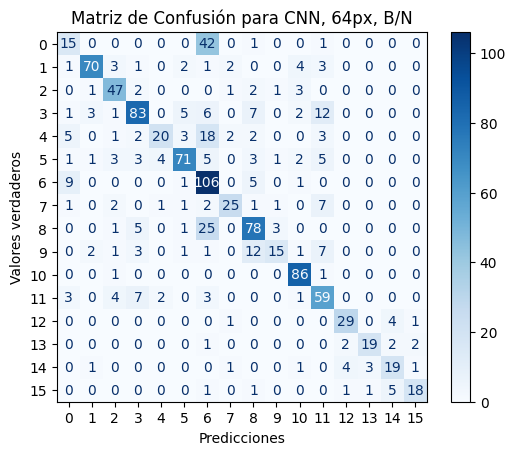

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Archivo de envío guardado como: CNN_submission_64_gray.csv
Entrenando modelo CNN con tamaño de imagen: 64 y Color


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.1760 - loss: 3.0539 - val_accuracy: 0.1044 - val_loss: 3.8868 - learning_rate: 0.0010
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 227ms/step - accuracy: 0.3755 - loss: 1.9654 - val_accuracy: 0.1636 - val_loss: 3.7520 - learning_rate: 0.0010
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 228ms/step - accuracy: 0.4653 - loss: 1.6462 - val_accuracy: 0.2338 - val_loss: 2.8906 - learning_rate: 0.0010
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 226ms/step - accuracy: 0.5169 - loss: 1.4441 - val_accuracy: 0.3762 - val_loss: 2.0603 - learning_rate: 0.0010
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - accuracy: 0.5498 - loss: 1.3265 - val_accuracy: 0.5166 - val_loss: 1.4698 - learning_rate: 0.0010
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 30s 220ms/step - accuracy: 0.5845 - loss: 1.2205 - val_accuracy: 0.5231 - val_loss: 1.6533 - learning_rate: 0.0010
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 32s 238ms/step - accuracy: 0.6

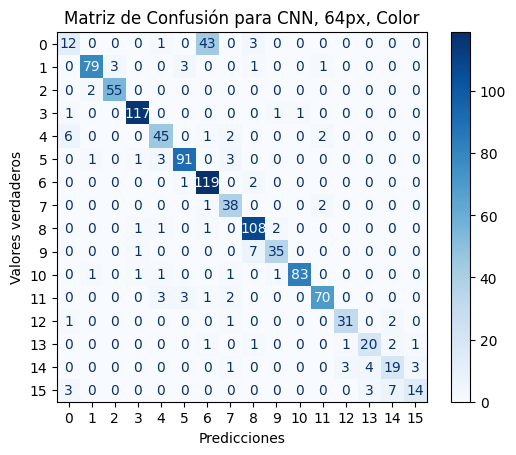

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Archivo de envío guardado como: CNN_submission_64_color.csv
Entrenando modelo CNN con tamaño de imagen: 128 y Blanco y Negro


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 101s 707ms/step - accuracy: 0.1182 - loss: 3.2265 - val_accuracy: 0.0832 - val_loss: 3.8778 - learning_rate: 0.0010
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 95s 696ms/step - accuracy: 0.1738 - loss: 2.7375 - val_accuracy: 0.1266 - val_loss: 3.1164 - learning_rate: 0.0010
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 94s 687ms/step - accuracy: 0.2172 - loss: 2.4686 - val_accuracy: 0.1599 - val_loss: 3.1742 - learning_rate: 0.0010
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 91s 670ms/step - accuracy: 0.2479 - loss: 2.3066 - val_accuracy: 0.1183 - val_loss: 3.3407 - learning_rate: 0.0010
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 93s 681ms/step - accuracy: 0.2854 - loss: 2.1309 - val_accuracy: 0.2976 - val_loss: 2.1369 - learning_rate: 0.0010
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 95s 695ms/step - accuracy: 0.3192 - loss: 2.0589 - val_accuracy: 0.2357 - val_loss: 2.2794 - learning_rate: 0.0010
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 96s 702ms/step - accuracy: 0.

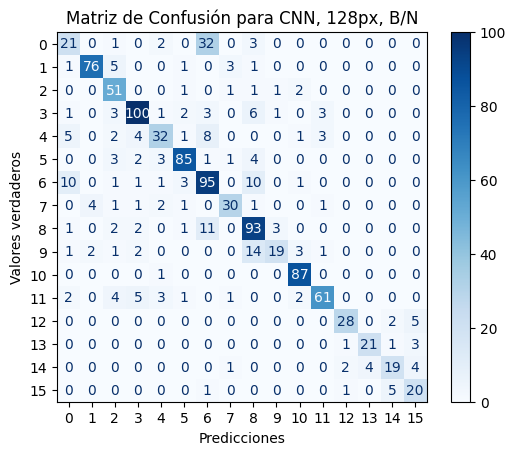

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step
Archivo de envío guardado como: CNN_submission_128_gray.csv
Entrenando modelo CNN con tamaño de imagen: 128 y Color


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 98s 681ms/step - accuracy: 0.1747 - loss: 2.9731 - val_accuracy: 0.1201 - val_loss: 4.5575 - learning_rate: 0.0010
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 94s 691ms/step - accuracy: 0.4036 - loss: 1.9025 - val_accuracy: 0.0527 - val_loss: 4.3279 - learning_rate: 0.0010
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 95s 699ms/step - accuracy: 0.4951 - loss: 1.5599 - val_accuracy: 0.2190 - val_loss: 3.9667 - learning_rate: 0.0010
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 91s 669ms/step - accuracy: 0.5381 - loss: 1.3636 - val_accuracy: 0.2458 - val_loss: 3.1549 - learning_rate: 0.0010
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 94s 691ms/step - accuracy: 0.5788 - loss: 1.2768 - val_accuracy: 0.3309 - val_loss: 2.4207 - learning_rate: 0.0010
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 93s 684ms/step - accuracy: 0.6001 - loss: 1.1544 - val_accuracy: 0.6349 - val_loss: 1.0699 - learning_rate: 0.0010
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 94s 691ms/step - accuracy: 0.6

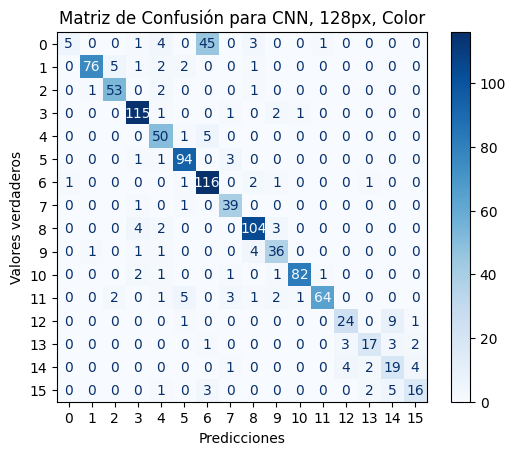

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step
Archivo de envío guardado como: CNN_submission_128_color.csv


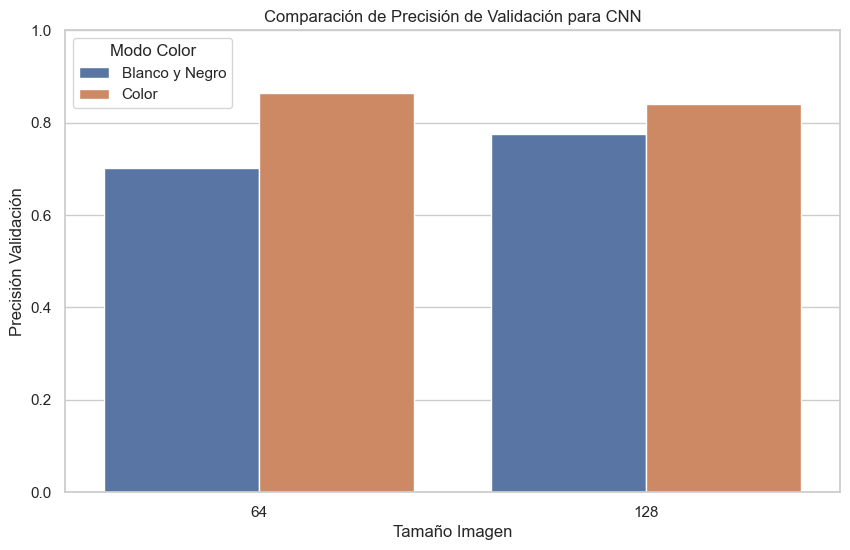

In [32]:
# Ejecutar el entrenamiento y evaluación en diferentes configuraciones
valAccuracies = []
sizes = []
colorModes = []

for size in [IMG_SIZE_LR, IMG_SIZE_CNN]:
    for grayscale in [True, False]:
        model, labelEncoder, valAccuracy = trainModel("CNN", size, grayscale)
        predictAndSubmit(model, size, grayscale, labelEncoder, "CNN")
        valAccuracies.append(valAccuracy)
        sizes.append(size)
        colorModes.append(grayscale)

# Graficar las precisiones de validación de los modelos entrenados
plotModelPerformance("CNN", valAccuracies, sizes, colorModes)

## Concluciones Sobre el Mejor Modelo de Red Convolucional (CNN) Conseguido

Considerando que entre las pruebas llevadas a cabo, cambiando el tamaño y el color de las imágenes en las entradas de las redes convolucionales entrenadas, observamos que entre la red que presenta mejores resultados es con las entradas a color y de menor dimensión, en este caso la mejor dimensión fue de 64, misma con la que se definió el modelo de regresión logística anteriormente.

## Comparación de los Resultados Entre La Regresión Logistica y La Red Convolucional (CNN)

### Precisión
- **Regresión Logística:** La precisión del modelo de regresión logística es baja, con un valor de 0.1312 aproximadamente. Esto indica que el modelo no es eficaz en clasificar correctamente las categorías de las imágenes.
- **Mejor CNN (64px, Color):** La CNN alcanzó una precisión de validación mucho mayor, de 0.8650 aproximadamente, lo que significa que este modelo es significativamente mejor para clasificar las imágenes que la regresión logística.

### Estructura de la Matriz de Confusión
- **Regresión Logística:** La matriz de confusión muestra una mayor dispersión de predicciones incorrectas. Observamos muchos valores no diagonales (errores), lo que indica que el modelo de regresión logística tiene dificultades para distinguir entre las diferentes clases.
- **CNN:** La matriz de confusión de la CNN muestra un patrón más definido, con la mayoría de las predicciones concentradas en la diagonal principal. Esto indica que la CNN clasifica correctamente la mayoría de las instancias en sus respectivas clases, logrando una mayor precisión en cada categoría.

### Errores en Categorías Específicas
- **Regresión Logística:** Los errores son comunes en casi todas las clases, y parece que no hay ninguna clase que destaque en precisión. Las predicciones incorrectas están distribuidas en varias clases, indicando que el modelo de regresión logística carece de capacidad para capturar patrones complejos en los datos.
  
- **CNN:** La CNN muestra que algunas clases tienen pocos errores (valores elevados en la diagonal), lo que indica que el modelo ha aprendido características distintivas para esas clases. Sin embargo, aún existen algunas clases con errores, aunque en menor proporción comparado con la regresión logística.
  
### Conclusiones
- **CNN Supera a Regresión Logística:** La CNN muestra una gran ventaja en rendimiento sobre la regresión logística, debido a su capacidad de capturar y procesar características espaciales de las imágenes, mientras que la regresión logística, siendo un modelo lineal, no puede capturar las complejidades necesarias para la clasificación de imágenes.